In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.linear_model as lm 
import sklearn.ensemble as em 
from sklearn.svm import SVC

In [3]:
import data_clean_for_model

In [4]:
import lightgbm as lgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)
rseed = 229

In [6]:
# download data 
# if you don't have these csvs, run the preprocessing notebook. 
# Ill turn this this into a py file later, but for now should be fine 
dfs = pd.read_parquet("data/all_processed_df.parquet.gzip")

In [7]:
k = 5
np.random.seed(rseed)
# add outcome var + unique id 
dfs['outcome'] = np.where(dfs['state']=="successful", 1, 0)
dfs['un_id'] = np.arange(0, dfs.shape[0], 1)
dfs['name_len'] = dfs['name'].str.len()
dfs['cv_group'] = np.random.choice(np.arange(0, k), size=dfs.shape[0])

In [8]:
dfs['binned_usd_goal'] = pd.qcut(np.log(dfs['usd_goal']+1), 20)

In [9]:
model_params = {
    'cv': True, 
    #'lnom_frac':0.3, 
    'test_frac':0.3, 
    'lnom_usdgoal':True,
    'dummies':True,
    'rseed': 229,
}

In [10]:
X_train, X_test, y_train, y_test = data_clean_for_model.data_clean_for_model(dfs, "outcome", model_params, cv=model_params['cv'])

In [12]:
# add naive bayes preds 
nb_proba_train = np.load("data/res/multi_nb_preds_train_big.npy")
nb_proba_test = np.load("data/res/multi_nb_preds_test_big.npy")
#nb_proba_train2 = np.load("data/res/multi_nb_preds_train_opt.npy")
#nb_proba_test2 = np.load("data/res/multi_nb_preds_test_opt.npy")
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()
# NB 
X_train_nb['nb_proba'] = nb_proba_train[:, 1]
X_test_nb['nb_proba'] = nb_proba_test[:, 1]
#X_train_nb['nb_proba2'] = nb_proba_train2[:, 1]
#X_test_nb['nb_proba2'] = nb_proba_test2[:, 1]

# W2V
w2v_train = np.load("data/res/w2v_Xtrain_avg_big.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg_big.npy")
X_train_nb_w2v = pd.concat((X_train_nb, pd.DataFrame(w2v_train)), axis=1)
X_test_nb_w2v = pd.concat((X_test_nb, pd.DataFrame(w2v_test)), axis=1)

# LDA 
lda_df = pd.read_csv("data/res/lda_df.csv").drop(columns=['Unnamed: 0'])
lda_df_test = pd.read_csv("data/res/lda_df_test.csv").drop(columns=['Unnamed: 0'])
X_train_nb_lda = pd.concat((X_train_nb, lda_df), axis=1)
X_test_nb_lda = pd.concat((X_test_nb, lda_df_test), axis=1)
X_train_nb_w2v_lda = pd.concat((X_train_nb_w2v, lda_df), axis=1)
X_test_nb_w2v_lda = pd.concat((X_test_nb_w2v, lda_df_test), axis=1)

In [109]:
export_to_sauren = False
if export_to_sauren: 

    import pickle 

    pkl_dict = {
        'naive_bayes_train':nb_proba_train[:, 1], 
        'naive_bayes_test':nb_proba_test[:, 1], 
        'lda_train':lda_df, 
        'lda_test':lda_df_test
    }
    assert (pkl_dict['lda_train'].shape[0] == X_train.shape[0]) and (pkl_dict['lda_test'].shape[0] == X_test.shape[0])
    assert (pkl_dict['naive_bayes_train'].shape[0] == X_train.shape[0]) and (pkl_dict['naive_bayes_test'].shape[0] == X_test.shape[0])

    f = open('data/pkl_dict.pkl', 'wb')
    pickle.dump(pkl_dict, f)
    f.close()

In [136]:
if export_to_sauren: 
    import pickle 
    pkl_dict = {
        'X_train':X_train_nb_lda, 
        'y_train':y_train, 
        'X_test':X_test_nb_lda, 
        'y_test':y_test
    }
    f = open('data/features.pkl', 'wb')
    pickle.dump(pkl_dict, f)
    f.close()

In [13]:
assert X_test.shape[0] == X_test_nb.shape[0] == X_test_nb_lda.shape[0] == X_test_nb_w2v.shape[0]== X_test_nb_w2v_lda.shape[0]
assert X_test.shape[0] + X_train.shape[0] == dfs.shape[0]

In [13]:
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.67, random_state=rseed)
filler = np.zeros(X_test_nb.shape)
X_eval_nb, X_test_nb, _, _ = train_test_split(X_test_nb, filler, test_size=0.67, random_state=rseed)
X_eval_nb_lda, X_test_nb_lda, _, _ = train_test_split(X_test_nb_lda, filler, test_size=0.67, random_state=rseed)
X_eval_nb_w2v, X_test_nb_w2v, _, _ = train_test_split(X_test_nb_w2v, filler, test_size=0.67, random_state=rseed)
X_eval_nb_w2v_lda, X_test_nb_w2v_lda, _, _ = train_test_split(X_test_nb_w2v_lda, filler, test_size=0.67, random_state=rseed)
assert X_test.shape[0] == X_test_nb.shape[0] == X_test_nb_lda.shape[0] == X_test_nb_w2v.shape[0]== X_test_nb_w2v_lda.shape[0]

In [ ]:
X_train = X_train.drop(columns=['binned_usd_goal_outcome_mean'])
X_test = X_test.drop(columns=['binned_usd_goal_outcome_mean'])

In [13]:
# specify some model performance funcs 
def rmse(y, yhat):
    print("RMSE:", np.round(np.sqrt( np.mean( (y - yhat)**2 ) ), 3))
    
def acc(y, yhat):
    yhat_rounded = np.round(yhat)
    print("Accuracy:", np.round(np.mean(yhat_rounded == y), 3))

In [16]:
## 1. Naive approach:
# Idea: what if we just guess the outcome of previous projects within this category
naive = np.array(np.round(X_test['cat_id_outcome_mean']).reset_index(drop=True))
rmse(y_test, naive)
acc(y_test, naive)

RMSE: 0.564
Accuracy: 0.681


In [11]:
N0_train = (y_train==0).sum()
N1_train = (y_train==1).sum()
N0_test = (y_test==0).sum()
N1_test = (y_test==1).sum()
train_weights = np.where(y_train==1, 0.5/N1_train, 0.5/N0_train)
test_weights = np.where(y_test==1, 0.5/N1_test, 0.5/N0_test)

In [137]:
## 1.5 OLS: 
ols = lm.LinearRegression(normalize=False)
ols.fit(X_train_nb_lda.drop(columns=['dummy_cat_id_1','dummy_cat_parent_id_1.0']), y_train, sample_weight=train_weights)
y_test_hat = ols.predict(X_test_nb_lda.drop(columns=['dummy_cat_id_1','dummy_cat_parent_id_1.0']))
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.375
Accuracy: 0.797


In [14]:
## 2. Lasso
# Since our feature space isn't that large and also not very rich (at least in a linear sense), don't expect great results here  
for a in [0.05, 0.25, 0.5, 0.75, 0.95]:
    print(a)
    clf_lasso = lm.Lasso(alpha=a, normalize=False, random_state=rseed)
    clf_lasso.fit(X_train, y_train, sample_weight=train_weights)
    y_test_hat = clf_lasso.predict(X_test)
    rmse(y_test, y_test_hat)
    acc(y_test, y_test_hat)

0.05
RMSE: 0.443
Accuracy: 0.712
0.25
RMSE: 0.45
Accuracy: 0.705
0.5
RMSE: 0.451
Accuracy: 0.705
0.75
RMSE: 0.452
Accuracy: 0.703
0.95
RMSE: 0.452
Accuracy: 0.703


In [135]:
## 3. Ridge
# Similar expectations to lasso, though at least it won't kick out features from our model, so should do a bit better  

# training procedure for a cross-validated ridge, but don't think this is necessary right now 
#clf_ridgecv = lm.RidgeCV(alphas=np.arange(0.1, 1, 0.02), cv=10).fit(X_train_lnom, y_train)
#print(clf_ridgecv.alpha_)
#y_test_hat = clf_ridgecv.predict(X_test_lnom)
#rmse(y_test, y_test_hat)
#acc(y_test, y_test_hat)
# train ridge 
clf_ridge = lm.Ridge(alpha=0.95, normalize=False, random_state=rseed)
clf_ridge.fit(X_train_nb_lda, y_train, sample_weight=train_weights)
y_test_hat = clf_ridge.predict(X_test_nb_lda)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.431
Accuracy: 0.727


/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.28424e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [140]:
## 4. Logistic Reg  
# Similar expectations to lasso + ridge 
# To avoid regularization set C to be very large and/or penalty to none 
glf = lm.LogisticRegression(C=100000, random_state=rseed, penalty='l2', class_weight='balanced')
glf.fit(X_train_nb_lda, y_train)
y_test_hat = glf.predict(X_test_nb_lda)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.604
Accuracy: 0.636


In [ ]:
svm = SVC(kernel='rbf', class_weight='balanced', random_state=rseed)
svm.fit(X_train_nb_lda, y_train)
y_test_hat = svm.predict(X_test_nb_lda)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

In [21]:
## 6. Random Forest (cont. )
# selected optimal params from cell above
best_params = {'bootstrap': False, 'max_depth': 65, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 30}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train, y_train)
y_test_hat = rf.predict(X_test)
y_test_hat_proba = rf.predict_proba(X_test)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

0    33483
1    32892
dtype: int64
RMSE: 0.448
Accuracy: 0.799


In [23]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.5, 
    feature_fraction=1, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
accuracy 0.8134689265536723
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     26428
           1       0.90      0.78      0.83     39947

    accuracy                           0.81     66375
   macro avg       0.81      0.82      0.81     66375
weighted avg       0.83      0.81      0.82     66375

[[22881  3547]
 [ 8834 31113]]


In [24]:
# acc: 0.8220263653483992
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb, y_train)
y_pred = clf.predict(X_test_nb)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's auc: 0.912233	valid's binary_logloss: 0.362896
accuracy 0.8198416981471488
              precision    recall  f1-score   support

           0       0.75      0.82      0.78     17754
           1       0.87      0.82      0.85     26718

    accuracy                           0.82     44472
   macro avg       0.81      0.82      0.81     44472
weighted avg       0.82      0.82      0.82     44472

[[14484  3270]
 [ 4742 21976]]


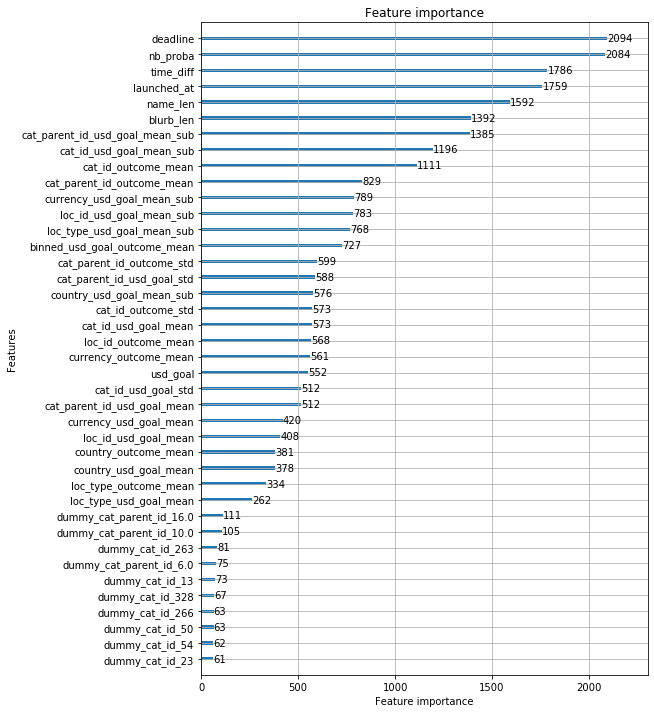

In [25]:
lgb.plot_importance(clf, max_num_features=40, figsize=(8, 12))

In [26]:
# BEST SO FAR 
drop_cols=[
    'country_outcome_mean', 'loc_id_usd_goal_mean', 'loc_type_usd_goal_mean', 'loc_type_outcome_mean'
]
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb.drop(columns=drop_cols), y_train)
y_pred = clf.predict(X_test_nb.drop(columns=drop_cols))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8225838041431262
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     26428
           1       0.87      0.83      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.82      0.82     66375
weighted avg       0.83      0.82      0.82     66375

[[21571  4857]
 [ 6919 33028]]


In [27]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8150508474576271
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     26428
           1       0.85      0.83      0.84     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.81      0.81     66375
weighted avg       0.82      0.82      0.82     66375

[[20773  5655]
 [ 6621 33326]]


In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()

In [59]:
X_train_nb_lda_scale = X_train_nb_lda.copy()
X_test_nb_lda_scale = X_test_nb_lda.copy()
scale_cols = ['deadline', 'launched_at', 'time_diff']
X_train_nb_lda_scale[scale_cols] = scaler.fit_transform(X_train_nb_lda[scale_cols])
X_test_nb_lda_scale[scale_cols] = scaler.fit_transform(X_test_nb_lda[scale_cols])
def df_to_log(df):
    return df.assign(
        usd_goal = lambda x:np.log(x['usd_goal']+1), 
        blurb_len = lambda x:np.log(x['blurb_len']+1), 
        name_len = lambda x:np.log(x['name_len']+1), 
    )
X_train_nb_lda_scale = df_to_log(X_train_nb_lda_scale)
X_test_nb_lda_scale = df_to_log(X_test_nb_lda_scale)

In [45]:
X_train_nb_lda.head()

,blurb_len,name_len,usd_goal,deadline,launched_at,time_diff,currency_outcome_mean,country_outcome_mean,cat_id_outcome_mean,cat_parent_id_outcome_mean,loc_id_outcome_mean,loc_type_outcome_mean,binned_usd_goal_outcome_mean,currency_usd_goal_mean,country_usd_goal_mean,cat_id_usd_goal_mean,cat_parent_id_usd_goal_mean,loc_id_usd_goal_mean,loc_type_usd_goal_mean,cat_id_outcome_std,cat_parent_id_outcome_std,cat_id_usd_goal_std,cat_parent_id_usd_goal_std,dummy_cat_id_1,dummy_cat_id_3,...,cat_id_usd_goal_mean_sub,cat_parent_id_usd_goal_mean_sub,loc_id_usd_goal_mean_sub,loc_type_usd_goal_mean_sub,nb_proba,lda_df_topic0,lda_df_topic1,lda_df_topic2,lda_df_topic3,lda_df_topic4,lda_df_topic5,lda_df_topic6,lda_df_topic7,lda_df_topic8,lda_df_topic9,lda_df_topic10,lda_df_topic11,lda_df_topic12,lda_df_topic13,lda_df_topic14,lda_df_topic15,lda_df_topic16,lda_df_topic17,lda_df_topic18,lda_df_topic19
0,90.0,8,99.742415,1500543720,1499726298,817422,0.644013,0.644013,1.000000,0.819209,0.599246,0.599514,0.776390,17707.055245,17707.055245,2887.774616,6083.873036,33943.732000,35187.682101,0.000000,0.384881,3948.587329,1.197831e+04,0,0,...,3.356021,4.100994,5.819922,5.855913,0.922235,0.007146,0.007146,0.007146,0.435541,0.007146,0.007146,0.007146,0.007146,0.007146,0.150042,0.007146,0.150033,0.007146,0.150054,0.007146,0.007146,0.007146,0.007146,0.007146,0.007146
1,90.0,37,3000.000000,1505057220,1503684209,1373011,0.609611,0.609611,0.599246,0.276027,0.599246,0.599514,0.663334,34526.292603,34526.292603,33943.732000,59425.459002,33943.732000,35187.682101,0.599246,0.447056,33943.732000,1.284018e+06,0,0,...,2.425788,2.985794,2.425788,2.461779,0.383927,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.132440,0.005558,0.005558,0.005558,0.656494,0.005558,0.005558,0.116583
2,125.0,60,2080.388739,1576958599,1575144199,1814400,0.644757,0.644757,1.000000,0.741845,0.599246,0.597463,0.651979,18984.553596,18984.553596,8875.708121,30046.683875,33943.732000,35150.604486,0.000000,0.437640,25441.463556,9.803122e+05,0,0,...,1.450395,2.669750,2.791698,2.826635,0.911862,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.205020,0.704968,0.005001
3,133.0,59,19000.000000,1522569564,1519549164,3020400,0.609898,0.609898,0.315436,0.272579,0.599246,0.599118,0.489512,32287.610271,32287.610271,40293.297993,52180.316849,33943.732000,32389.680283,0.464831,0.445312,281055.034269,1.229953e+06,0,0,...,0.751718,1.010233,0.580242,0.533379,0.545735,0.003848,0.003848,0.462753,0.080795,0.003848,0.003848,0.003848,0.003848,0.003848,0.003848,0.235659,0.082392,0.003848,0.003848,0.003848,0.003848,0.003848,0.003848,0.003848,0.080687
4,135.0,50,12000.000000,1426881600,1424900240,1981360,0.609611,0.609611,0.599246,0.341223,0.751023,0.599514,0.576349,34526.292603,34526.292603,33943.732000,77477.275862,13757.951335,35187.682101,0.599246,0.474139,33943.732000,1.287538e+06,0,0,...,1.039744,1.865008,0.136700,1.075735,0.740705,0.004168,0.004168,0.004168,0.004168,0.089062,0.286073,0.087501,0.004168,0.004168,0.004168,0.004168,0.004168,0.170849,0.004168,0.303994,0.004168,0.004168,0.004168,0.004168,0.004168


In [60]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_lda_scale.drop(columns='binned_usd_goal_outcome_mean'), y_train)
y_pred = clf.predict(X_test_nb_lda_scale.drop(columns='binned_usd_goal_outcome_mean'))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.823954802259887
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.82      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[21757  4671]
 [ 7014 32933]]


In [98]:
# 0.824225988700565
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0, 
    importance_type='gain'
)
clf.fit(X_train_nb_lda.drop(columns='binned_usd_goal_outcome_mean'), y_train)
y_pred = clf.predict(X_test_nb_lda.drop(columns='binned_usd_goal_outcome_mean'))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.824225988700565
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[21965  4463]
 [ 7204 32743]]


In [44]:
# acc -> 0.824225988700565
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_lda, y_train)
y_pred = clf.predict(X_test_nb_lda)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.824225988700565
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[21965  4463]
 [ 7204 32743]]


In [104]:
impt_df = pd.DataFrame(data={
    'var':X_train_nb_lda.drop(columns='binned_usd_goal_outcome_mean').columns, 
    'impt':clf.feature_importances_
}).sort_values('impt')
least_important_vars = impt_df.query("impt < 1")['var']
least_important_vars_all = np.concatenate((least_important_vars, ['binned_usd_goal_outcome_mean']))
least_important_vars_all

array(['dummy_cat_id_290', 'dummy_cat_id_300', 'dummy_cat_id_317',
       'dummy_cat_id_386', 'dummy_cat_id_1', 'dummy_cat_id_352',
       'dummy_cat_id_355', 'dummy_cat_id_354',
       'binned_usd_goal_outcome_mean'], dtype=object)

In [100]:
# acc -> 0.824316384180791
lf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0, 
    importance_type='gain'
)
lf.fit(X_train_nb_lda.drop(columns=least_important_vars_all), y_train)
y_pred = lf.predict(X_test_nb_lda.drop(columns=least_important_vars_all))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.824316384180791
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[22100  4328]
 [ 7333 32614]]


In [105]:
impt_df = pd.DataFrame(data={
    'var':X_train_nb_lda.drop(columns=least_important_vars_all).columns, 
    'impt':lf.feature_importances_
}).sort_values('impt')
least_important_vars2 = impt_df.query("impt < 1")['var']
print(least_important_vars2)
least_important_vars_all = np.concatenate((least_important_vars_all, least_important_vars2))

141    dummy_cat_id_321
28      dummy_cat_id_12
160    dummy_cat_id_340
91     dummy_cat_id_268
Name: var, dtype: object


In [106]:
################# MAIN MODEL 
# acc -> 0.8244067796610169
lf2 = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0, 
    importance_type='gain'
)
lf2.fit(X_train_nb_lda.drop(columns=least_important_vars_all), y_train)
y_pred = lf2.predict(X_test_nb_lda.drop(columns=least_important_vars_all))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8244067796610169
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[22085  4343]
 [ 7312 32635]]


In [123]:
def optimal_lgbm(random_seed):
    lf2 = lgb.LGBMClassifier(
        random_state=random_seed, 
        is_unbalance=True, 
        bagging_fraction=0.75, 
        feature_fraction=0.2, 
        max_depth = 55, 
        max_bin = 500, 
        num_leaves = 400, 
        lambda_l1 = 0,
        lambda_l2 = 0, 
        importance_type='gain', 
        verbose=-1
    )
    lf2.fit(X_train_nb_lda.drop(columns=least_important_vars_all), y_train)
    y_pred = lf2.predict(X_test_nb_lda.drop(columns=least_important_vars_all))
    return accuracy_score(y_pred, y_test)

In [124]:
acc = []
for r in np.arange(1, 10, 1):
    acc.append( optimal_lgbm( rseed + r ) )
print(acc)
print(np.mean(acc))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warni

In [107]:
impt_df = pd.DataFrame(data={
    'var':X_train_nb_lda.drop(columns=least_important_vars_all).columns, 
    'impt':lf2.feature_importances_
}).sort_values('impt')
least_important_vars2 = impt_df.query("impt < 1")['var']
print(least_important_vars2)
#least_important_vars_all = np.concatenate((least_important_vars_all, least_important_vars2))

Series([], Name: var, dtype: object)


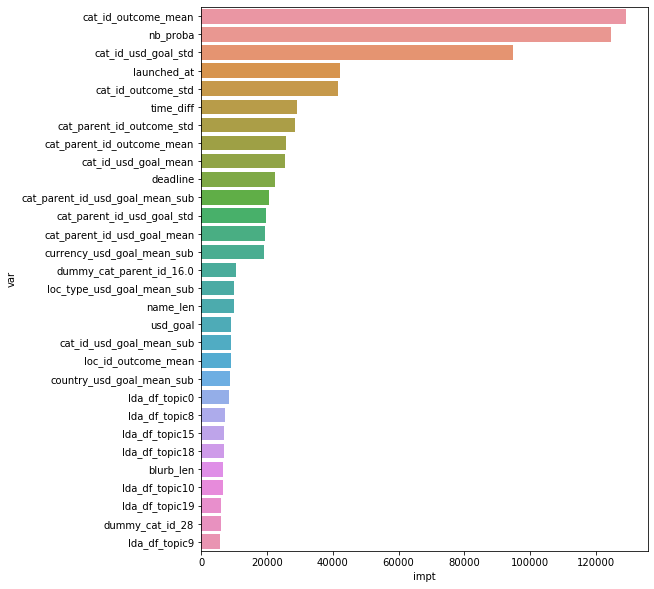

In [119]:
tmp = impt_df.sort_values('impt', ascending=False).head(30)
plt.subplots(1,1, figsize=(8, 10))
sns.barplot(y=tmp['var'], x=tmp['impt'])

In [52]:
# acc -> 0.824316384180791
lf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
lf.fit(X_train_nb_lda.drop(columns=least_important_vars), y_train)
y_pred = lf.predict(X_test_nb_lda.drop(columns=least_important_vars))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.824316384180791
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[22100  4328]
 [ 7333 32614]]


In [21]:
grid_search_params = {
    'max_depth':[65],
    'num_leaves': [400, 500, 600], 
    'max_bin': [400, 500, 600], 
    #'min_child_samples': sp_randint(150, 300), 
    #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 10],
    'bagging_fraction': [0.7, 0.8, 1], 
    'feature_fraction': [0.5, 0.7, 1],
    'lambda_l1': [0, 1e-1, 1, 2, 5, 10, 50],
    'lambda_l2': [0, 1e-1, 1, 5, 10, 20, 50]
}

In [28]:
lgbmm = lgb.LGBMClassifier(random_state=rseed, verbose=-1, n_jobs=4, is_unbalance=True, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=lgbmm, 
    param_distributions=grid_search_params, 
    n_iter=100,
    scoring='accuracy',
    refit=True,
    cv=2,
    random_state=rseed+5,
    verbose=2,
    n_jobs=4,
)

In [37]:
gs.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.539280958876815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.539280958876815
[LightGBM] [Warning] bagging_fraction is set=0.8192641499726137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192641499726137


RandomizedSearchCV(cv=2,
                   estimator=LGBMClassifier(is_unbalance=True, n_jobs=4,
                                            random_state=229, verbose=-1),
                   n_iter=100, n_jobs=4,
                   param_distributions={'bagging_fraction': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4b0ab45b0>,
                                        'feature_fraction': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4b0ab4f40>,
                                        'lambda_l1': [0, 0.1, 1, 2, 5, 10, 50,
                                                      100],
                                        'lambda_l2': [0, 0.1, 1, 5, 10, 20, 50,
                                                      100],
                                        'max_bin': [500],
                                        'max_depth': [55, 60, 65, 70, 75, 80,
                                                      85, 90],
                                        'num

In [38]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
ypred = gs.predict(X_test)
print('accuracy %s' % accuracy_score(ypred, y_test))
print(classification_report(y_test, ypred))

Best score reached: 0.8118329190752414 with params: {'bagging_fraction': 0.8192641499726137, 'feature_fraction': 0.539280958876815, 'lambda_l1': 1, 'lambda_l2': 10, 'max_bin': 500, 'max_depth': 65, 'num_leaves': 400} 


In [41]:
gs.fit(X_train_nb_lda, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.7552439982264174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552439982264174
[LightGBM] [Warning] bagging_fraction is set=0.2980783318095253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2980783318095253


RandomizedSearchCV(cv=2,
                   estimator=LGBMClassifier(is_unbalance=True, n_jobs=4,
                                            random_state=229, verbose=-1),
                   n_iter=100, n_jobs=4,
                   param_distributions={'bagging_fraction': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4b0ab45b0>,
                                        'feature_fraction': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4b0ab4f40>,
                                        'lambda_l1': [0, 0.1, 1, 2, 5, 10, 50,
                                                      100],
                                        'lambda_l2': [0, 0.1, 1, 5, 10, 20, 50,
                                                      100],
                                        'max_bin': [500],
                                        'max_depth': [55, 60, 65, 70, 75, 80,
                                                      85, 90],
                                        'num

In [29]:
gs.fit(
    X_train_nb_lda, y_train,
    early_stopping_rounds=100, 
    eval_metric = 'binary', 
    eval_set = [(X_test_nb_lda, y_test)],
    eval_names =['valid']
)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[1]	valid's binary_logloss: 0.630992
Training until validation scores don't improve for 100 rounds
[2]	valid's binary_logloss: 0.596204
[3]	valid's binary_logloss: 0.567249
[4]	valid's binary_logloss: 0.543078
[5]	valid's binary_logloss: 0.522296
[6]	valid's binary_logloss: 0.504311
[7]	valid's binary_logloss: 0.489119
[8]	valid's binary_logloss: 0.476977
[9]	valid's binary_logloss: 0.465599
[10]	valid's binary_logloss: 0.455187
[11]	valid's binary_logloss: 0.446414
[12]	valid's binary_logl

RandomizedSearchCV(cv=2,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            n_estimators=1000, n_jobs=4,
                                            random_state=229, verbose=-1),
                   n_iter=100, n_jobs=4,
                   param_distributions={'bagging_fraction': [0.7, 0.8, 1],
                                        'feature_fraction': [0.5, 0.7, 1],
                                        'lambda_l1': [0, 0.1, 1, 2, 5, 10, 50],
                                        'lambda_l2': [0, 0.1, 1, 5, 10, 20, 50],
                                        'max_bin': [400, 500, 600],
                                        'max_depth': [65],
                                        'num_leaves': [400, 500, 600]},
                   random_state=234, scoring='accuracy', verbose=2)

In [30]:
gs.best_estimator_

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.7, is_unbalance=True,
               lambda_l1=0, lambda_l2=50, max_bin=400, max_depth=65,
               n_estimators=1000, n_jobs=4, num_leaves=400, random_state=229,
               verbose=-1)

In [20]:
gs.best_estimator_

LGBMClassifier(bagging_fraction=0.673226899113038,
               feature_fraction=0.8853537231098203, is_unbalance=True,
               lambda_l1=0, lambda_l2=50, max_bin=600, max_depth=65, n_jobs=4,
               num_leaves=400, random_state=229, verbose=-1)

In [31]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
ypred = gs.predict(X_test_nb_lda)
print('accuracy %s' % accuracy_score(ypred, y_test))
print(classification_report(y_test, ypred))

Best score reached: 0.8571345614075507 with params: {'num_leaves': 400, 'max_depth': 65, 'max_bin': 400, 'lambda_l2': 50, 'lambda_l1': 0, 'feature_fraction': 0.7, 'bagging_fraction': 0.8} 
accuracy 0.8209566854990584
              precision    recall  f1-score   support

           0       0.75      0.82      0.78     26428
           1       0.87      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.82      0.82     66375
weighted avg       0.82      0.82      0.82     66375



In [42]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))
ypred = gs.predict(X_test_nb_lda)
print('accuracy %s' % accuracy_score(ypred, y_test))
print(classification_report(y_test, ypred))

Best score reached: 0.8571991284403393 with params: {'bagging_fraction': 0.2980783318095253, 'feature_fraction': 0.7552439982264174, 'lambda_l1': 0, 'lambda_l2': 10, 'max_bin': 500, 'max_depth': 90, 'num_leaves': 400} 
accuracy 0.8201280602636535
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     26428
           1       0.87      0.83      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.82      0.81     66375
weighted avg       0.82      0.82      0.82     66375



In [39]:
tmp = gs.best_estimator_
tmp.fit(X_train_nb_lda.drop(columns='binned_usd_goal_outcome_mean'), y_train, 
           early_stopping_rounds=100, 
    eval_metric = 'binary', 
    eval_set = [(X_test_nb_lda.drop(columns='binned_usd_goal_outcome_mean'), y_test)],
    eval_names =['valid']
       )
yhat = tmp.predict(X_test_nb_lda.drop(columns='binned_usd_goal_outcome_mean'))
print(classification_report(y_test, yhat))

[1]	valid's binary_logloss: 0.631915
Training until validation scores don't improve for 100 rounds
[2]	valid's binary_logloss: 0.596952
[3]	valid's binary_logloss: 0.567522
[4]	valid's binary_logloss: 0.543395
[5]	valid's binary_logloss: 0.52231
[6]	valid's binary_logloss: 0.50427
[7]	valid's binary_logloss: 0.489254
[8]	valid's binary_logloss: 0.4763
[9]	valid's binary_logloss: 0.46525
[10]	valid's binary_logloss: 0.456024
[11]	valid's binary_logloss: 0.447662
[12]	valid's binary_logloss: 0.441281
[13]	valid's binary_logloss: 0.433638
[14]	valid's binary_logloss: 0.428275
[15]	valid's binary_logloss: 0.421588
[16]	valid's binary_logloss: 0.417424
[17]	valid's binary_logloss: 0.414274
[18]	valid's binary_logloss: 0.411134
[19]	valid's binary_logloss: 0.408254
[20]	valid's binary_logloss: 0.405576
[21]	valid's binary_logloss: 0.401178
[22]	valid's binary_logloss: 0.397168
[23]	valid's binary_logloss: 0.393416
[24]	valid's binary_logloss: 0.390302
[25]	valid's binary_logloss: 0.389131
[2

In [41]:
print('accuracy %s' % accuracy_score(yhat, y_test))

accuracy 0.8207909604519774
